# Statistic for AI and Data Science - Coursework 2

     
 1. Data Preparation
     1. Addition of New Variables
     1. Material and Design
     1. Outliers
 
 1. Exploratory Analysis
     
 1. Regression Modelling
     1. Model Construction
     1. Coefficient of Determination & Residuals
     1. Regression Coefficients
     1. Conclusion

## 1. Data Preparation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

See the first five rows of the data below. We possess data on a total of 34,293 bridges.

In [6]:
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
display(bridges.head())

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


### A. Addition of New Variables

We introduce the 'Age' column by taking the 'Year' away from 2024. We remove from our data all bridges that are possibly historic, as their inclusion may affect the generalisability of our results to newer structures. We also remove all data for bridges for which at least one '_rating' field is populated by 'NA'. Next, we convert the ordinal variables in the 'Deck_rating', 'Superstr_rating' and 'Substr_rating' columns to numerical values. We do so by mapping the value 'Failed' to 1, 'Failing' to 2, up to a value of 9 for 'Excellent'. Lastly, we introduce the column 'Condition' which is given by the sum of the three '_rating' columns. The first five rows of our data, filtering only for the five predictor variables and the target variable ('Condition') can be seen below.

In [9]:
bridges.loc[:,'Age'] = 2024 - bridges.Year
bridges = bridges.loc[bridges.Historic == 'Not historic']
bridges = bridges[(bridges['Deck_rating'] != 'NA') & 
                  (bridges['Superstr_rating'] != 'NA') & 
                  (bridges['Substr_rating'] != 'NA')]
rating_map = {
    'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4,
    'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9}
bridges['Deck_rating'] = bridges['Deck_rating'].map(rating_map).astype(float)
bridges['Superstr_rating'] = bridges['Superstr_rating'].map(rating_map).astype(float)
bridges['Substr_rating'] = bridges['Substr_rating'].map(rating_map).astype(float)
bridges['Condition'] = bridges[['Deck_rating', 'Superstr_rating', 'Substr_rating']].sum(axis=1)

bridges_2 = bridges[['Age', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Condition']].copy()

bridges_2.head()

,Age,AverageDaily,Trucks_percent,Material,Design,Condition
Structure_id,,,,,,
000021521-00101,19,1,0.0,Concrete,Slab,23.0
000021521-00181,19,1,0.0,Concrete,Slab,22.0
000021521-TMP20,12,100,0.0,Concrete,Beam,24.0
000021525-00012,74,80,0.0,Timber,Beam,18.0
000021580-00092,20,150,4.0,Concrete,Beam,23.0


### B. Material and Design

The code cell below outputs a count of the different bridge designs present in the data.

In [12]:
bridges_2.Design.value_counts()

Design
Beam          17743
Slab           1045
Other           996
Arch             79
Frame            26
Truss            13
Movable           7
Suspension        3
Name: count, dtype: int64

As design types below 'Other' have such few instances, their inclusion may lead to unreliable insights. As such, we subsume them all into the 'Other' category. This will likely make regression easier to perform.

The below cell outputs a count of the different material types used in the bridges in the data.

In [14]:
bridges_2.loc[~bridges['Design'].isin(['Beam', 'Slab', 'Other']), 'Design'] = 'Other'
bridges_2.Material.value_counts()

Material
Concrete    15985
Steel        3534
Timber        352
Other          40
Masonry         1
Name: count, dtype: int64

Using similar rationale to above, we remove all data on bridges composed of 'Other' or 'Masonry'.

In [16]:
bridges_2 = bridges_2.loc[~bridges['Material'].isin(['Other', 'Masonry'])]

In [17]:
bridges_2 = bridges_2.dropna(subset=['Material', 'Design'])

if isinstance(bridges_2['Material'].dtype, pd.CategoricalDtype):
    bridges_2['Material'] = bridges_2['Material'].cat.remove_unused_categories()
if isinstance(bridges_2['Design'].dtype, pd.CategoricalDtype):
    bridges_2['Design'] = bridges_2['Design'].cat.remove_unused_categories()

### C. Outliers

See the below summary statistics for our three, numerical predictors and target variable.

In [20]:
bridges_2.describe()

,Age,AverageDaily,Trucks_percent,Condition
count,19871.000000,19871.000000,19871.000000,19871.000000
mean,25.531025,11833.330733,6.271753,21.090031
std,11.478148,25477.709273,8.595380,1.757748
min,5.000000,0.000000,0.000000,0.000000
25%,16.000000,190.000000,0.000000,20.000000
50%,25.000000,2950.000000,3.000000,21.000000
75%,35.000000,12100.000000,10.000000,22.000000
max,94.000000,543000.000000,99.000000,27.000000


Note that the removal of data in the last section has reduced the number of bridges on which data is present to 19,871.

The summary statistics indicate a large variation in our values of 'AverageDaily', 'Trucks_percent' and 'Condition'. Zero or near-zero values in 'AverageDaily' and 'Trucks_percent' likely represent pedestrian-only or light-vehicle bridges. Likewise, low 'Condition' scores indicate bridges in disrepair. Keeping these values in our model is essential to ensure we account for low-usage and at-risk structures.

High 'AverageDaily' counts and 'Trucks_percent' values reflect heavily trafficked bridges or bridges used nearly exclusively for industrial purposes. Their inclusion is crucual to understand the impact that high loads have on bridge condition.

We therefore proceed with all 19,871 data points. Distributions of our variables are found in the next section.

## 2. Exploratory Analysis

The aim of this section is to gain a preliminary understanding of the data and to identify any notable patterns or relationships. We examime the relationship between each predictor variable and the target, hoping to uncover influences of the former on the latter. We also examine the relationship between the predictors themselves as any strong correlations between our predictors can greatly complicate our regression modelling.

We begin with a heatmap of our continuous variables (all variables other than bridge type and material). Each cell in the below heatmap gives the correlation coefficient between the variables in the column and row. Note that the correlation between two variables can take a value between -1 and +1, with -1 indicating a perfect, negative correlation and +1 indicating a positive correlation.

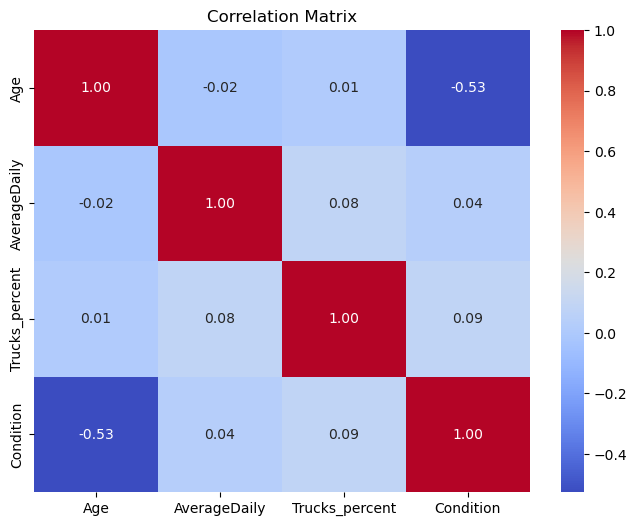

In [24]:
continuous_vars = ['Age', 'AverageDaily', 'Trucks_percent']
correlation_matrix = bridges_2[continuous_vars + ['Condition']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The largest correlation exists between the age of a bridge and its condition. A correlation coefficient of -0.53 indicates a moderately strong, negative correlation between the age of a bridge and its condition. As the age of a bridge increases, its condition deteriorates. So much is to be expected. As the correlation coefficient between age and condition is significantly higher than any other, we expect the age of a bridge to have a greater predictive influence on a bridge's condition than any other variable.

None of our continuous predictors have strong correlations between themselves. A correlation coefficient of -0.02 exists between 'AverageDaily' and 'Age', 0.01 between 'Trucks_percent' and 'Age', and 0.08 between 'Trucks_percent' and 'AverageDaily'. This indicates that regression modelling ought to work well for our dataset. The latter result, a a slight positive correlation of 0.08 between 'Trucks_percent' and 'AverageDaily' is feasible. A bridge used by many vehicles might also be of use to industry.

As for the relationship between our other predictors and condition, a correlation coefficient of 0.04 exists between 'AverageDaily' and 'Condition' and 0.09 between 'Trucks_percent' and 'Condition'. Both are fairly weak, positive correlations. They tell us that as the number of vehicles that use a bridge increase, so does the condition slightly. Though somewhat counterintuitive, this may be the result of bridges that are more frequently used being under greater scrutiny by maintainer authorities and therefore repaired more often.

See the below three scatter plots of bridge condition against our three, continuous, predictor variables.

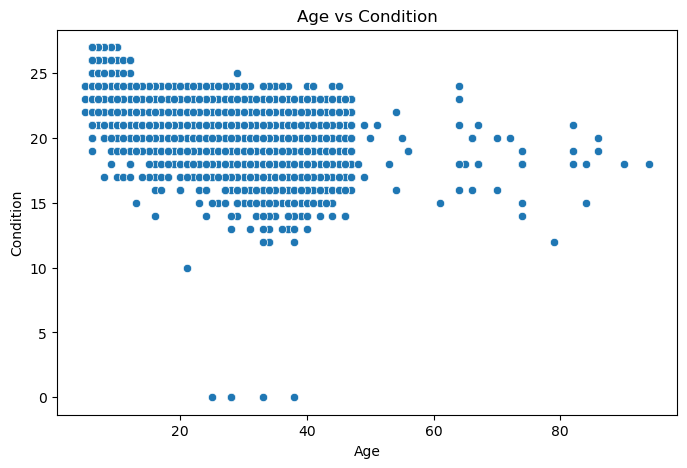

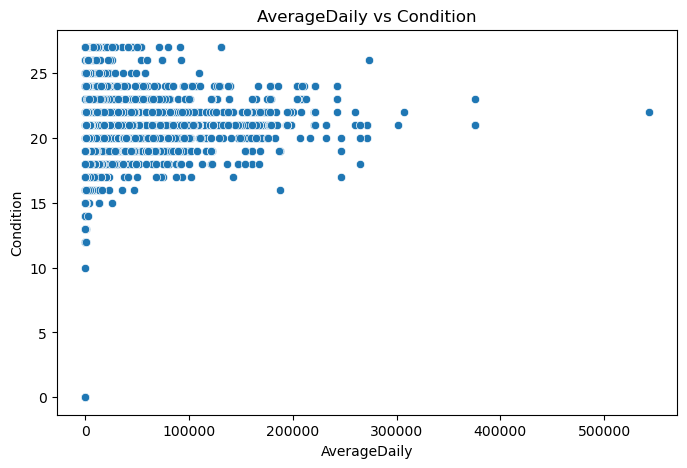

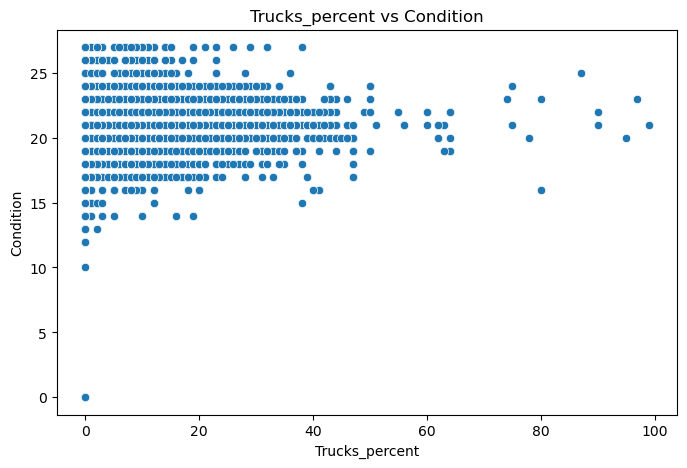

In [26]:
for var in continuous_vars:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=bridges_2, x=var, y='Condition')
    plt.title(f'{var} vs Condition')
    plt.xlabel(var)
    plt.ylabel('Condition')
    plt.show()

We observe a negative correlation between the age of a bridge and its condition. The other two plots show a lack of concrete correlation between the predictors and target. The x-axis of the three plots shows the vastly different scales that our three, continuous predictor variables exist on. This is something that needs to be considered and scaled prior to regression.

We next focus on the relationship between bridge condition and our two, categorical predictors, bridge design and material. The plot below is a boxplot of bridge design against condition.

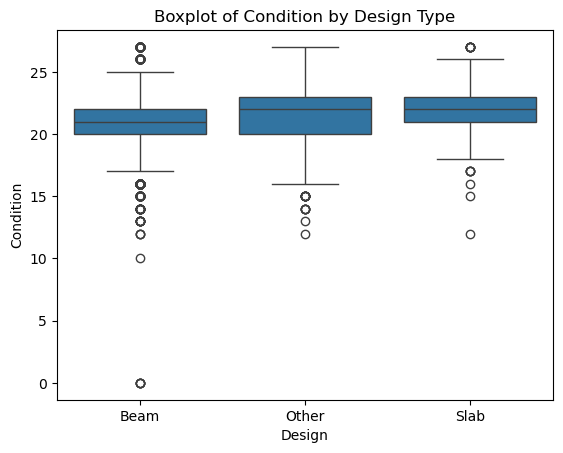

In [28]:
import seaborn as sns
sns.boxplot(x='Design', y='Condition', data=bridges_2)
plt.title('Boxplot of Condition by Design Type')
plt.show()

Beam bridges have the highest range of values for condition and the lowest median. Beam bridges significantly outnumber the other two types, and so it is reasonable for their condition to be the most varied. The 'Other' category has the largest interquartile range and slab bridges have the highest median. The 'Other' category having the greatest IQR is expected due to the consolidation into it that we performed for the other bridge types. 

See the number of each bridge type below.

In [30]:
bridges_2.Design.value_counts()

Design
Beam     17743
Other     1083
Slab      1045
Name: count, dtype: int64

Now doing the same but for bridge material:

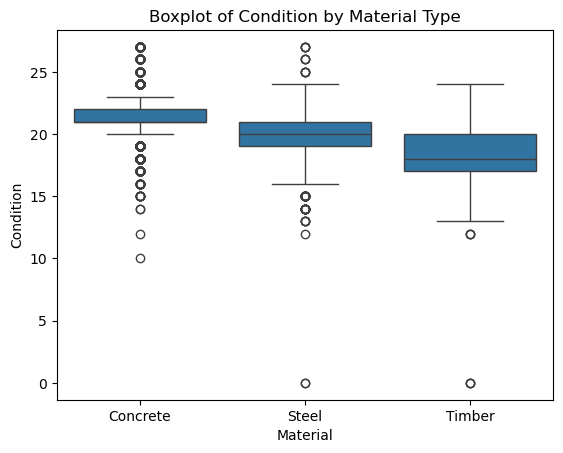

In [32]:
sns.boxplot(x='Material', y='Condition', data=bridges_2)
plt.title('Boxplot of Condition by Material Type')
plt.show()

Concrete bridges have the highest median condition, followed by steel and timber. Timber bridges have the highest interquartile range, followed by steel and concrete. See the number of each material below.

In [34]:
bridges_2.Material.value_counts()

Material
Concrete    15985
Steel        3534
Timber        352
Name: count, dtype: int64

Now, focusing on bridge material first, we generate plots of our three remaining, continuous predictor variables against themselves and against the target variable, condition. The legend indicates the colour
that each material is represented as.

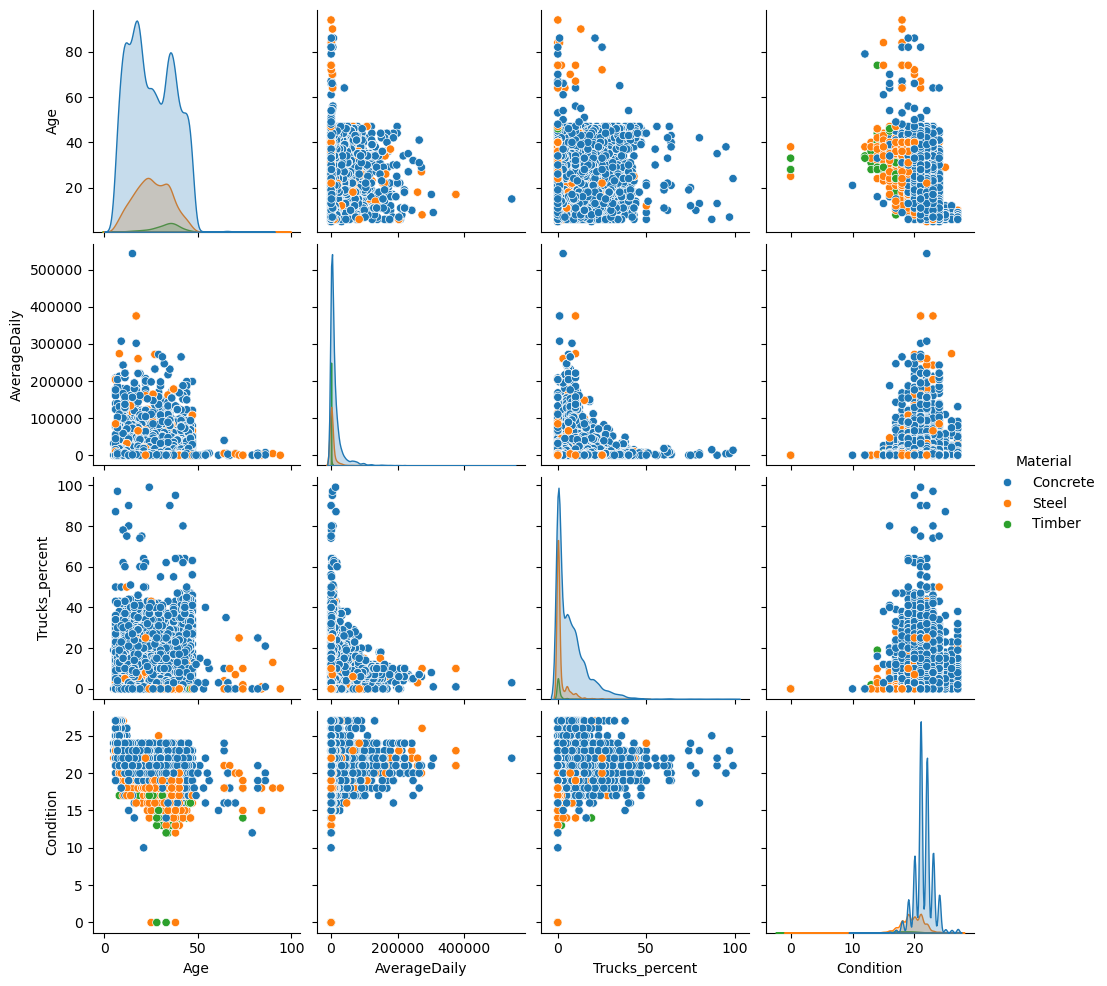

In [36]:
sns.pairplot(bridges_2, hue='Material')
plt.show()

Drawing your attention to the plots on the diagonal first, (1,1), (2,2), (3,3) and (4,4) - where (x,y) indicates row x and column y - these are plots of the distributions of our continuous variables. The x-axis of these plots gives the variable being distributed, e.g., age in the case of (1,1). Contrary to the plots' axis, the y-axis gives the frequency. (1,1) shows that most of the bridges are composed of concrete, etc. Concrete bridges have a large spread in terms of their age but the oldest bridges tend to be steel ones. Plot (2,2) is a plot of 'AverageDaily' against frequency. A significant majority of our bridges have less than 200,000 vehicles traversing daily. As the other plots in column two indicate, there exist bridges with over 400,000 daily vehicles, but these are a minority. (3,3) shows that most of the bridges with higher 'Trucks_percent' are composed of concrete. (4,4) gives a picture of the distribution of bridge condition. Concrete bridges have a greater spread tend to be in better condition that timber and steel ones.

We have already seen plots (4,1), (4,2) and (4,3) above. But this time, with the inclusion of different colours for bridge materials, (4,1) shows that concrete bridges tend to be in much better condition that the other two materials. As (4,2) and (4,3) show, there is no clear relationship between a bridge's condition and 'AverageDaily' or 'Trucks_percent'.

Other plots are of one predictor against another. The lack of a 'pattern' in these plots is expected after looking at our correlation matrix above, which shows that our predictors do not influence one another much.

We plot sixteen other plots below. This time the different colours correspond to different bridge types. The below plots are somewhat less informative that the above ones.

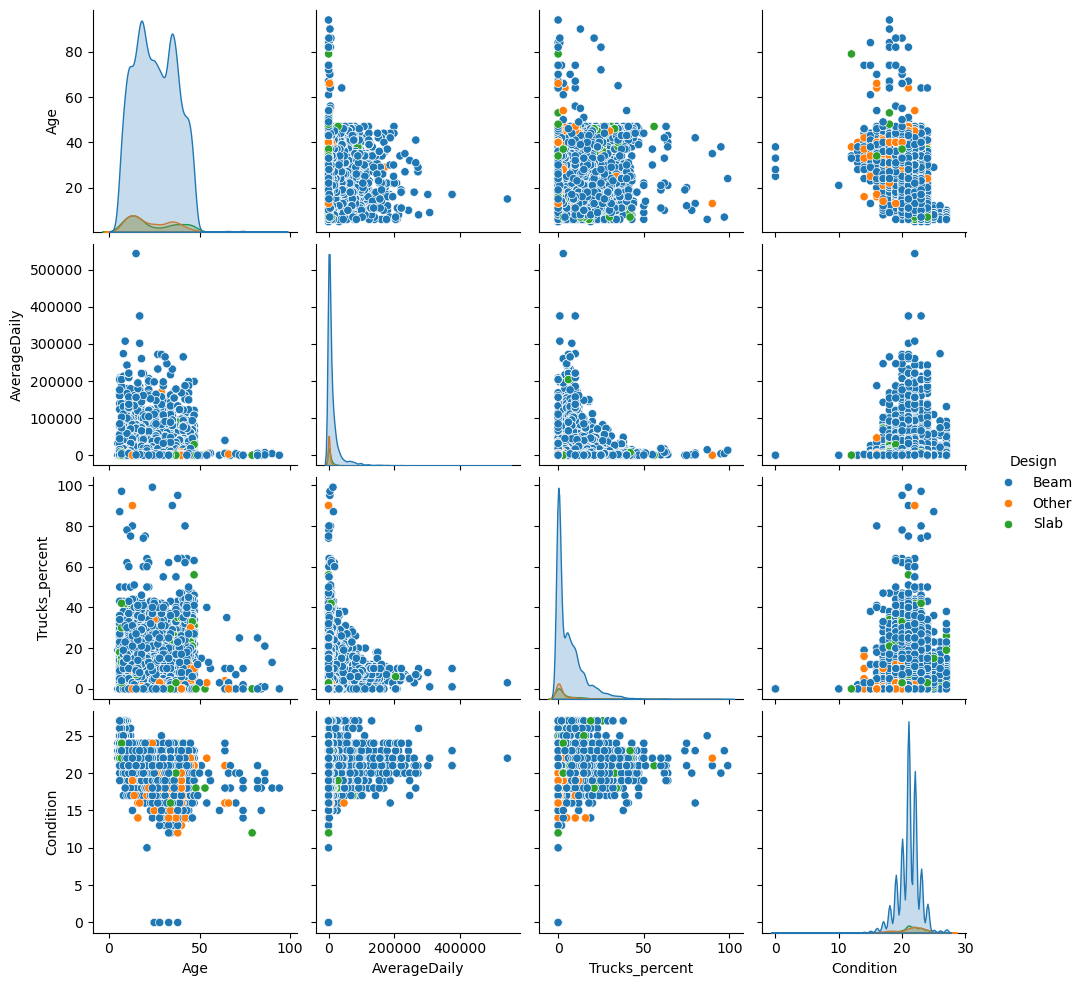

In [38]:
sns.pairplot(bridges_2, hue='Design')
plt.show()

## 3. Regression Modelling

We will now explore the relationships between our predictors and target by constructing a multiple linear regression model. We will assess how well the predictors can explain or predict the condition of bridges and determine the strength and direction of each predictor's influence. We arrive at a result for R-squared, or the coefficient of determination for our model. The coefficient of determination gives the proportion of variability in the target variable that can be explained by our variables. An R-squared value of 0.7, for example, indicates that 70% of the variability of the data is attributable to our target variables. The higher the R-squared value, the better a linear model 'fits'.

The equation of a multiple linear regression model can be expressed as:

$$
Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \ldots + \beta_nX_n + \epsilon
$$

Where:
- \( Y \) is the predicted value of the target variable (dependent variable).
- The coefficients are represented as:

  $$
  \beta_1, \beta_2, \ldots, \beta_n
  $$

  corresponding to each predictor variable:

  $$
  X_1, X_2, \ldots, X_n
  $$

  These coefficients represent the expected change in \( Y \) for a one-unit increase in each respective \( X \), holding all other predictors constant.


The higher the value of a beta coefficient, the greater the influence of that predictor variable on the target.

### A. Model Construction

We make a few changes to our data in order to allow a better regression model to form. First, the categorical variables, 'Design' and 'Material' are converted to numerical form. This is necessary as linear regression require numerical inputs.

Next, we standardise our continuous variables, 'Age', 'Trucks_percent' and 'AverageDaiy'. As mentioned in section 2, these three variables take on vastly different numerical values. Their standardisation allows for comparability across the predictors. We use z-score standardisation, which rescales these variables to have a mean of 0 and unit standard deviation.

In [44]:
bridges_2 = pd.get_dummies(bridges_2, columns=['Material', 'Design'], drop_first=True)

scaler = StandardScaler()
continuous_vars = ['Age', 'AverageDaily', 'Trucks_percent']
bridges_2[continuous_vars] = scaler.fit_transform(bridges_2[continuous_vars])

X = bridges_2.drop(columns=['Condition'])
y = bridges_2['Condition']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

### B. Coefficient of Determination & Residuals

In [46]:
r_squared = model.score(X, y)
print(f"R² (Coefficient of Determination): {r_squared:.3f}")

R² (Coefficient of Determination): 0.462


The coefficient of determination of our model is 0.462. This means that 46.2% of the variability in our data is accounted for by our predictor variables. A significant portion of the variability in our data, over 50%, is, however, not accounted for. This suggests that additional factors not included in our model influence bridge condition to a great extent.

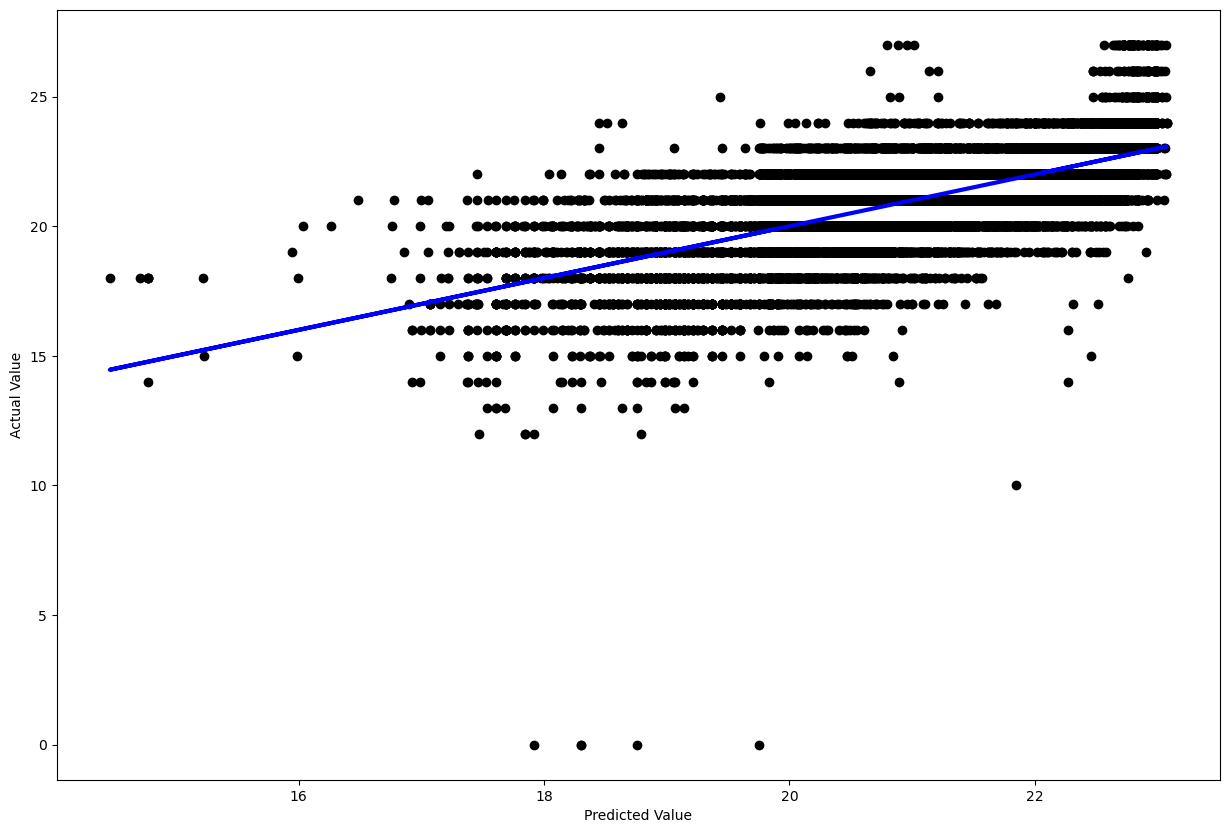

In [48]:
predictions = model.predict(X)
residuals = y - predictions

fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(predictions, y,  color='black')
a.plot(predictions, predictions, color='blue', linewidth=3)
a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')
plt.show()

The plot above is of the predicted values of bridge condition against their actual conditions as contained in the data. The plot aims to give a visual representation of how well our models's predictions align with actual bridge conditions.

The blue line marks the line Actual Value = Predicted Value. Were our model perfect, we would observe all of our data points exactly along this diagonal line, as our model's predictions would completely align with the actual bridge conditions. We observe that while most of our data does cluster around this line, there are noticeable exceptions, e.g., the four data points that almost straddle the x-axis. Further, our data points seem to cluster at predicted values greater than 18: there are very few data points at predicted values less than 18. This implies that our model performs better for bridges in better condition than for bridges in worse condition. Ths points to the need for further refinement in our model, possibly by the inclusion of additional variables that may correlate more strongly with bridge deterioration.

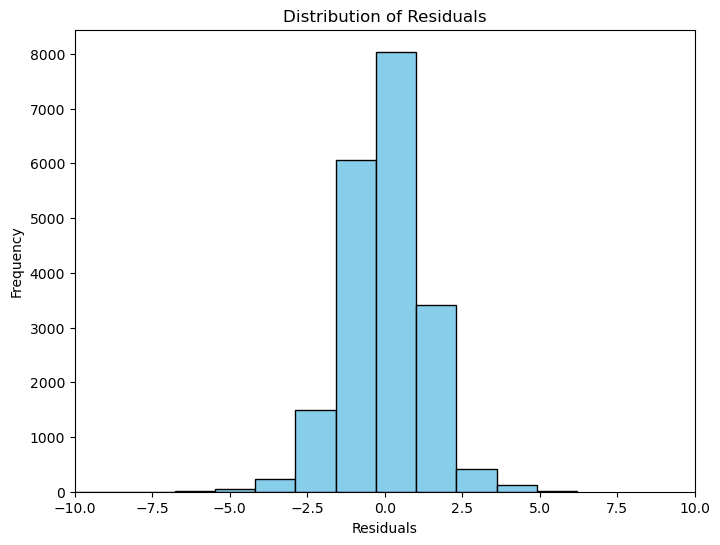

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.xlim(-10, 10)
plt.show()

The histogram above is of residuals against frequency. Residuals, in this context, are the differences between our actual data and our predicted data. In our case, the residual values are calculated by taking the difference between a bridge's actual condition and a bridge's predicted condition as per our model. This process can be visualised on our scatter graph above. For every point, we draw a vertical line towards the actual = predicted line and measure its length. The length of such a line gives the value of its residual. When the actual value for a bridge's condition is greater than the predicted value, we get positive residuals. And we get negative residual values when our predicted value is greater than the actual.

A perfect model would have no residuals. A good, realistic model ought to have residuals normally distributed and centred around 0. 

Our residual histogram does appear to be somewhat normally distributed and is roughly centred around 0. This tells us that our model does an effective job at predicting some bridge conditions. Our residual plot is not perfectly symmetric. This implies that our model at times overestimates a bridge's condition, whilst underestimating its condition at other times.

### C. Regression Coefficients

In [51]:
coefficients = pd.Series(model.coef_, index=X.columns)
print("Regression Coefficients:")
print(coefficients)

Regression Coefficients:
Age               -0.880209
AverageDaily      -0.033490
Trucks_percent    -0.039064
Material_Steel    -1.786632
Material_Timber   -3.008457
Design_Other       0.035556
Design_Slab        0.068113
dtype: float64


The above cell output gives the regression or beta coefficients for our target variables. Again, beta coefficients indicate the expected change in the target variable for a unit increase in the corresponding predictor variable, whilst holding all other predictors constant. For all three of our continuous variables, the regression coefficients are negative. This indicates that an increase in any of these three variables results in a decrease in bridge condition. As expected, the age of a bridge has the greatest impact on its condition. A regression coefficient value of -0.88 indicates that increasing the age of a bridge by one year results in a 0.88 point decrease in bridge condition. 'AverageDaily' and 'Trucks_percent' have much weaker influences on bridge condition. A unit increase in either of these variables results in a decrease in a bridge's condition by around 0.03 points.

The last four beta coefficient values, from 'Material_Steel' to 'Design_Slab' require explanation. The conversion of our 'Material' and 'Design' categories to numerical values requires the creation of a 'base' category. For 'Material', 'Concrete' was chosen as the base category, and for 'Design' it was 'Beam'. These final four results, then, do not give the absolute beta coefficients for these categories, but are instead comparisons with the base categories. A beta coefficient of -1.79 for 'Material_Steel' indicates that a bridge made of steel is expected to have a 'Condition' 1.79 times lower than a concrete bridge (the base category). Timber bridges, therefore, have conditions over 3 times worse than concrete ones. Whilst for design, beam bridges perform the worst, followed by 'Other' and 'Slab'.

Beta coefficients have units which are given by the dimensions of the target variable divided by the dimensions of the predictor. A bridge's condition is unitless. The same is true for 'AverageDaily' - being just a number. The same is also true for our 'Design' and 'Material' categories. The beta coefficients for all predictors, therefore, are unitless other than the coefficient for 'Age', which has units of reciprocal years, or $\text{years}^{-1}.
$


### D. Conclusion

The regression model has revealed that a bridge's age and the material it is composed of (especially timber and steel compared to concrete) have the most significant impact on its condition. This alligns with our expectations as older bridges made of steel or timber show greater signs of wear.

We have arrived at a coefficient of determination of 0.462. This indicates that 46% of the variability in a bridge's condition can be explained solely by our model's predictors. Thus, despite having some success, our model still leaves a majority of the variability in our data unexplauned.

This points to the need to expand our model, possibly by the introduction of additional predictor variables, such as environmental exposure, maintenance frequency, etc., which may more completely predict a bridge's condition.